# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time

# Data loading
Remember to change path if needed

In [2]:
# path = "D:/GitHub/Machine-Learning/Kaggle/"
path = "C:/Users/Javi/Documents/GitHub/Machine-Learning/Kaggle/"

zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

# Data split & Spectrum in regular bins
Data is split between a proper training set (later used in cross-validation), and a test_train set, which will help us in determining under/overfitting as we do have labels for them.

Spectrums are divided in regular size bins, always the same, so that we can treat them as features, not worrying about different mz scales. According to the literature the peaks contain the relevant information, then we only save the maximum value in the bin (range of mz coordinates) so that peak information is never lost. Moreover, by performing this regularization in bins, peaks at very close mz values (same compound, small mz differences due to experimental uncertainty) are seen by the machine as belonging to the same bin and therefore the same feature. Therefore, it facilitates to use peaks as values.

Also, peak values are normalized by the maximum peak value of the spectrum, as specific values are experiment-dependent and do not carry information, only the relation between peak sizes does.

In [3]:
def spectrum_in_bins(df,m,M,bin_size):
    # Now, let's define the mz ranges, and the label associated to each of them (the mean of the limiting values of each bin)
    range_min = []; range_max = []; range_label = [];
    for mz in range(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_label.append(np.mean([range_min[-1],range_max[-1]]).astype(int))


    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum
                idx_data_in_bins[0,i] = 0   

        # Normalize the amplitude of the spectrum
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / np.max(idx_data_in_bins[0,:])
        
        
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_label, index = df.index)
    return new_df

In [4]:
# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

m = 2000; M = 20000; 
bin_size = 50;

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.2, random_state=42) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

# apply the bins to all spectra, so that our feature space becomes the same for all samples (make them regular, all the same)
spectrum_train = spectrum_in_bins(data_train,m,M,bin_size)
spectrum_test_train = spectrum_in_bins(data_test_train,m,M,bin_size)
print('Spectrum regularized!')
# these spectrum_... are our X for training

Training samples: 412 and test_train samples: 104
Spectrum regularized!


# Try different classifiers
The try_clf function has been built for, given a classifier and a parameter dictionary (for hyperparameter cross-validation), create a classifier for each antibiotic, and return the results. This enables for fast testing of different classifiers. Moreover, the function also takes charge of suppressing NaN values in the targets ocurring for amikacina, levofloxacino and tobramicina.

In [ ]:
def try_clf(clf,params,n_cv=5):
    t1 = time.time()
    
    best_classifiers = [];
    accuracies_train = []; accuracies_test_train = [];
    AUC_train = []; AUC_test_train = [];
    
    # Selection of train and test data (depending on whether there are NaN target values)
    for antibiotic_idx in range(len(targets_train.columns.values)):
        column_name = [df_train.columns.values[1+antibiotic_idx]]
        
        print()
        print(column_name) # indicate in which antibiotic we are
        
        if (df_train[column_name].isnull().sum() > 0).all(): # if there are NaN values, we should remove those samples
#             print('There are NaN values in',column_name)
            merged_train = pd.concat([spectrum_train , targets_train],axis=1,copy=True)
            merged_test_train = pd.concat([spectrum_test_train, targets_test_train],axis=1)
            clean_train = merged_train.dropna(subset=column_name)
#             print('Dropped ',len(merged_train)-len(clean_train),' from training set')
            clean_test_train = merged_test_train.dropna(subset=column_name)
#             print('Dropped ',len(merged_test_train)-len(clean_test_train),' from test_training set')

            Y_train = clean_train.iloc[:,-9+antibiotic_idx].to_numpy().reshape(-1,)
            Y_test_train = clean_test_train.iloc[:,-9+antibiotic_idx].to_numpy().reshape(-1,)
            X_train = clean_train.iloc[:,:-9]
            X_test_train = clean_test_train.iloc[:,:-9]
        else:
            Y_train = targets_train.iloc[:,antibiotic_idx].to_numpy().reshape(-1,)
            Y_test_train = targets_test_train.iloc[:,antibiotic_idx].to_numpy().reshape(-1,)
            X_train = spectrum_train.copy(deep=True)
            X_test_train = spectrum_test_train.copy(deep=True)
            
        # perform a GridSearchCV in order to train a classifier for this antibiotic
        grid = GridSearchCV(clf,param_grid=params, cv=n_cv, iid=False)
        grid.fit(X_train, Y_train)

        # print the best parameters (to detect edge values), and save that classifier
        print('The best parameters are: ',grid.best_params_)
        best_clf = grid.best_estimator_
        best_classifiers.append(best_clf)
        
        # compute the accuracy of the classifier
        acc_train = best_clf.score(X_train, Y_train)
        acc_test = best_clf.score(X_test_train, Y_test_train)
        print('Train accuracy: ',np.round(acc_train,4),' and test_train accuracy: ',np.round(acc_test,4))
        accuracies_train.append(acc_train)
        accuracies_test_train.append(acc_test)
        
        # compute the AUC of the classifier
        if callable(getattr(best_clf,"predict_proba",None)):
            pred_train = best_clf.predict_proba(X_train)[:,-1] # only take last column, the prob of Y = +1
            pred_test = best_clf.predict_proba(X_test_train)[:,-1]
        else:
            print('Using decision_function instead of predict_proba')
            pred_train = best_clf.decision_function(X_train)
            pred_test = best_clf.decision_function(X_test_train)            
        auc_score_train = roc_auc_score(Y_train, pred_train)
        auc_score_test = roc_auc_score(Y_test_train, pred_test)
        print('Train AUC: ',np.round(auc_score_train,4),' and test_train AUC: ',np.round(auc_score_test,4))
        AUC_train.append(auc_score_train)
        AUC_test_train.append(auc_score_test)
        
    avg_AUC_train = np.mean(AUC_train)
    avg_AUC_test_train = np.mean(AUC_test_train)
    print('\n\nThe average train AUC is',np.round(avg_AUC_train,4),'and the avg test_train AUC is',np.round(avg_AUC_test_train,4))
    
    t2 = time.time()
    print('\nFull execution took ',np.round(t2-t1,1),'seconds')
    print('\nDONE!')
    return best_classifiers, accuracies_train, accuracies_test_train, AUC_train, AUC_test_train

## Logistic regressor classifier

In [14]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1e6, solver='lbfgs')
params = {'C':10.**np.arange(-5,5)}
lr_best_clfs, _, _, lr_AUC_train, lr_AUC_test_train = try_clf(clf,params)


['OXACILINA']
The best parameters are:  {'C': 100.0}
Train accuracy:  0.8228  and test_train accuracy:  0.75
Train AUC:  0.9086  and test_train AUC:  0.7906

['AMIKACINA']
The best parameters are:  {'C': 100.0}
Train accuracy:  0.8468  and test_train accuracy:  0.7683
Train AUC:  0.8959  and test_train AUC:  0.706

['AMOXI/CLAV']
The best parameters are:  {'C': 100.0}
Train accuracy:  0.8301  and test_train accuracy:  0.75
Train AUC:  0.9062  and test_train AUC:  0.7771

['CIPROFLOXACINO']
The best parameters are:  {'C': 100.0}
Train accuracy:  0.835  and test_train accuracy:  0.7692
Train AUC:  0.8871  and test_train AUC:  0.7741

['CLINDAMICINA']
The best parameters are:  {'C': 1e-05}
Train accuracy:  0.7961  and test_train accuracy:  0.7788
Train AUC:  0.6269  and test_train AUC:  0.6991

['ERITROMICINA']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.8544  and test_train accuracy:  0.6827
Train AUC:  0.9017  and test_train AUC:  0.7049

['LEVOFLOXACINO']
The best param

In [36]:
# let's now try with balanced class weights
clf = LogisticRegression(max_iter=1e6, solver='lbfgs',class_weight='balanced')
params = {'C':10.**np.arange(-5,5)}
lr_balanced_best_clfs, _, _, lr_balanced_AUC_train, lr_balanced_AUC_test_train = try_clf(clf,params,3)


['OXACILINA']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.8932  and test_train accuracy:  0.7404
Train AUC:  0.9554  and test_train AUC:  0.8335

['AMIKACINA']
The best parameters are:  {'C': 100.0}
Train accuracy:  0.8324  and test_train accuracy:  0.6829
Train AUC:  0.9032  and test_train AUC:  0.7294

['AMOXI/CLAV']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.8859  and test_train accuracy:  0.7404
Train AUC:  0.9543  and test_train AUC:  0.8102

['CIPROFLOXACINO']
The best parameters are:  {'C': 100.0}
Train accuracy:  0.8034  and test_train accuracy:  0.7404
Train AUC:  0.8902  and test_train AUC:  0.7793

['CLINDAMICINA']
The best parameters are:  {'C': 10000.0}
Train accuracy:  0.9126  and test_train accuracy:  0.6923
Train AUC:  0.9762  and test_train AUC:  0.6621

['ERITROMICINA']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.8155  and test_train accuracy:  0.6827
Train AUC:  0.905  and test_train AUC:  0.7122

['LEVOFLOXACINO']
The b

In [43]:
# let's now try with balanced class weights
clf = LogisticRegression(max_iter=1e6, solver='lbfgs',class_weight='balanced')
params = {'C':10.**np.arange(-5,5)}
lr_balanced_best_clfs, _, _, lr_balanced_AUC_train, lr_balanced_AUC_test_train = try_clf(clf,params,10)


['OXACILINA']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.8932  and test_train accuracy:  0.7404
Train AUC:  0.9554  and test_train AUC:  0.8335

['AMIKACINA']
The best parameters are:  {'C': 10000.0}
Train accuracy:  0.9335  and test_train accuracy:  0.7439
Train AUC:  0.9861  and test_train AUC:  0.7544

['AMOXI/CLAV']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.8859  and test_train accuracy:  0.7404
Train AUC:  0.9543  and test_train AUC:  0.8102

['CIPROFLOXACINO']
The best parameters are:  {'C': 10000.0}
Train accuracy:  0.9005  and test_train accuracy:  0.75
Train AUC:  0.973  and test_train AUC:  0.8179

['CLINDAMICINA']
The best parameters are:  {'C': 1e-05}
Train accuracy:  0.7961  and test_train accuracy:  0.7788
Train AUC:  0.627  and test_train AUC:  0.6986

['ERITROMICINA']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.8155  and test_train accuracy:  0.6827
Train AUC:  0.905  and test_train AUC:  0.7122

['LEVOFLOXACINO']
The bes

In [44]:
# let's now try with balanced class weights
clf = LogisticRegression(max_iter=1e6, solver='lbfgs',class_weight='balanced')
params = {'C':10.**np.arange(-2,6)}
lr_balanced_best_clfs, _, _, lr_balanced_AUC_train, lr_balanced_AUC_test_train = try_clf(clf,params,5)


['OXACILINA']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.8932  and test_train accuracy:  0.7404
Train AUC:  0.9554  and test_train AUC:  0.8335

['AMIKACINA']
The best parameters are:  {'C': 10000.0}
Train accuracy:  0.9335  and test_train accuracy:  0.7439
Train AUC:  0.9861  and test_train AUC:  0.7544

['AMOXI/CLAV']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.8859  and test_train accuracy:  0.7404
Train AUC:  0.9543  and test_train AUC:  0.8102

['CIPROFLOXACINO']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.8495  and test_train accuracy:  0.7692
Train AUC:  0.9361  and test_train AUC:  0.814

['CLINDAMICINA']
The best parameters are:  {'C': 100000.0}
Train accuracy:  0.9757  and test_train accuracy:  0.7019
Train AUC:  0.9988  and test_train AUC:  0.6449

['ERITROMICINA']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.8155  and test_train accuracy:  0.6827
Train AUC:  0.905  and test_train AUC:  0.7122

['LEVOFLOXACINO']
Th

In [45]:
# let's now try with balanced class weights
clf = LogisticRegression(max_iter=1e6, solver='lbfgs',class_weight='balanced')
params = {'C':10.**np.arange(-2,6)}
lr_balanced_best_clfs, _, _, lr_balanced_AUC_train, lr_balanced_AUC_test_train = try_clf(clf,params,10)


['OXACILINA']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.8932  and test_train accuracy:  0.7404
Train AUC:  0.9554  and test_train AUC:  0.8335

['AMIKACINA']
The best parameters are:  {'C': 10000.0}
Train accuracy:  0.9335  and test_train accuracy:  0.7439
Train AUC:  0.9861  and test_train AUC:  0.7544

['AMOXI/CLAV']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.8859  and test_train accuracy:  0.7404
Train AUC:  0.9543  and test_train AUC:  0.8102

['CIPROFLOXACINO']
The best parameters are:  {'C': 10000.0}
Train accuracy:  0.9005  and test_train accuracy:  0.75
Train AUC:  0.973  and test_train AUC:  0.8179

['CLINDAMICINA']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.835  and test_train accuracy:  0.6635
Train AUC:  0.9277  and test_train AUC:  0.6906

['ERITROMICINA']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.8155  and test_train accuracy:  0.6827
Train AUC:  0.905  and test_train AUC:  0.7122

['LEVOFLOXACINO']
The be

In [ ]:
plt.figure(figsize=(20,10))
col_names = targets_train.columns.values
plt.plot(col_names,lr_AUC_test_train,label='Unbalanced LR')
plt.plot(col_names,lr_balanced_AUC_test_train,label='Balanced LR')
plt.title('AUC for test_train set')
plt.legend()
plt.show()

### Important note
It is better to use balanced class weights (in general), and also a 10-fold cross-validation instead of 5.

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
params = {'n_neighbors':np.arange(1,40)}
knn_best_clfs, _, _, knn_AUC_train, knn_AUC_test_train = try_clf(clf,params,10)

## SVM - Linear

In [65]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', class_weight='balanced')
params = {'C':10.**np.arange(-3,7)}
linear_SVM_best_clfs, _, _, linear_SVM_AUC_train, linear_SVM_AUC_test_train = try_clf(clf,params,10)


['OXACILINA']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.9126  and test_train accuracy:  0.7788
Train AUC:  0.9623  and test_train AUC:  0.8462

['AMIKACINA']
The best parameters are:  {'C': 100.0}
Train accuracy:  0.8497  and test_train accuracy:  0.7317
Train AUC:  0.9164  and test_train AUC:  0.7157

['AMOXI/CLAV']
The best parameters are:  {'C': 10000.0}
Train accuracy:  0.9563  and test_train accuracy:  0.7115
Train AUC:  0.9869  and test_train AUC:  0.8187

['CIPROFLOXACINO']
The best parameters are:  {'C': 100.0}
Train accuracy:  0.8252  and test_train accuracy:  0.7788
Train AUC:  0.8995  and test_train AUC:  0.8023

['CLINDAMICINA']
The best parameters are:  {'C': 100000.0}
Train accuracy:  0.9903  and test_train accuracy:  0.7404
Train AUC:  0.9963  and test_train AUC:  0.6653

['ERITROMICINA']
The best parameters are:  {'C': 100.0}
Train accuracy:  0.7913  and test_train accuracy:  0.6827
Train AUC:  0.8565  and test_train AUC:  0.7251

['LEVOFLOXACINO']
The

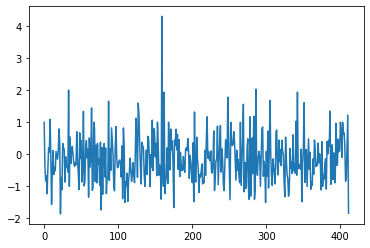

0.6995506535947713


In [59]:
clf = SVC(kernel='linear', class_weight='balanced').fit(spectrum_train,targets_train.iloc[:,0].to_numpy().reshape(-1,))
plt.plot(clf.decision_function(spectrum_train))
plt.show()

antibiotic_idx = 0
Y_test_train = targets_test_train.iloc[:,antibiotic_idx].to_numpy().reshape(-1,)
X_test_train = spectrum_test_train.copy(deep=True)

pred_test_train = clf.decision_function(X_test_train)
print(roc_auc_score(Y_test_train,pred_test_train))

I don't really know what SVC.decision_function is returning, because as we can see in the plot above, it is btw -2 and 4, not between 0 and 1. Therefore, it is not probabilities.

Now, let's try with the option "probability" = True, than although making it slower, it enables predict_proba.

In [70]:
clf = SVC(kernel='linear', class_weight='balanced', probability=True)
params = {'C':10.**np.arange(-3,7)} 
linear_SVM_prob_best_clfs, _, _, linear_SVM_prob_AUC_train, linear_SVM_prob_AUC_test_train = try_clf(clf,params,10)


['OXACILINA']
The best parameters are:  {'C': 1000.0}
Train accuracy:  0.9126  and test_train accuracy:  0.7788
Train AUC:  0.9623  and test_train AUC:  0.8464

['AMIKACINA']
The best parameters are:  {'C': 100.0}
Train accuracy:  0.8497  and test_train accuracy:  0.7317
Train AUC:  0.9163  and test_train AUC:  0.7157

['AMOXI/CLAV']
The best parameters are:  {'C': 10000.0}
Train accuracy:  0.9563  and test_train accuracy:  0.7115
Train AUC:  0.9869  and test_train AUC:  0.8187

['CIPROFLOXACINO']
The best parameters are:  {'C': 100.0}
Train accuracy:  0.8252  and test_train accuracy:  0.7788
Train AUC:  0.8994  and test_train AUC:  0.8023

['CLINDAMICINA']
The best parameters are:  {'C': 100000.0}
Train accuracy:  0.9903  and test_train accuracy:  0.7404
Train AUC:  0.9963  and test_train AUC:  0.6653

['ERITROMICINA']
The best parameters are:  {'C': 100.0}
Train accuracy:  0.7913  and test_train accuracy:  0.6827
Train AUC:  0.8565  and test_train AUC:  0.7251

['LEVOFLOXACINO']
The

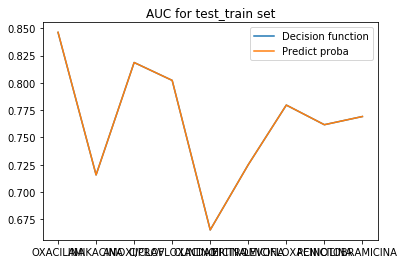

In [76]:
plt.figure()
col_names = targets_train.columns.values
plt.plot(col_names,linear_SVM_AUC_test_train,label='Decision function')
plt.plot(col_names,linear_SVM_prob_AUC_test_train,label='Predict proba')
plt.title('AUC for test_train set')
plt.legend()
plt.show()

In [ ]:
np.asarray(linear_SVM_AUC_test_train) - np.asarray(linear_SVM_prob_AUC_test_train)

Ok, it looks like both are yielding the same results, and using probability = True takes much more time. So, it will not be used from now on.

## SVM - Polynomial

In [ ]:
clf = SVC(kernel='poly', class_weight='balanced')

C_vector = 10. ** np.arange(-6,3)
gamma_vector = 10. ** np.arange(-4,4)
degree_vector = [1,2,3]
params = {'C':C_vector, 'gamma':gamma_vector, 'degree':degree_vector}

poly_SVM_best_clfs, _, _, poly_SVM_AUC_train, poly_SVM_AUC_test_train = try_clf(clf,params,10)

## SVM - RBF

In [ ]:
clf = SVC(kernel='rbf', class_weight='balanced')

C_vector = 10. ** np.arange(-4,4)
gamma_vector = 10. ** np.arange(-4,4)
params = {'C':C_vector, 'gamma':gamma_vector}

poly_SVM_best_clfs, _, _, rbf_SVM_AUC_train, rbf_SVM_AUC_test_train = try_clf(clf,params,10)